### Let's play with LSTM's
In this notebook I will explore lstms for the task of time seq generation. Time sequence generation is a really important task in robotics, especially if you are dealing with trajectory predictions. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#### Generating a sine wave
We will want our network to learn a sine wave. For that we will need to generate multiple sequences of a sine wave. 

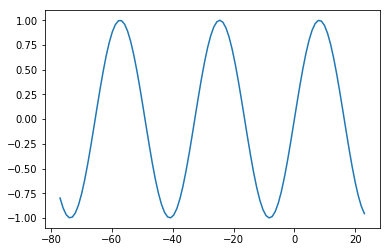

In [27]:
def generate_sample(batch_size = 2, seqlength = 100, show_plot=False,freq=11):
    lower = np.random.randint(-100, 100, size=batch_size)
    higher = lower + seqlength
    x = np.linspace(lower, higher, seqlength).T
    y = np.sin((x * np.pi/180*freq))
    if show_plot:
        plt.plot(x[1], y[1])
        plt.show()
    return torch.from_numpy(y).float()

input = generate_sample(show_plot=True)

#### Defining Network Related Stuff

In [28]:
epochs = 10
num_samples = 10
batch_size = 10
seqlength = 1000

#### Defining the LSTM model 
We will use two stacked lstm for this task. 
Be careful while using reshape. 

In [77]:
class network(nn.Module):
    def __init__(self, hidden_size=101):
        super(network, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(input_size=1, hidden_size=self.hidden_size)
        self.lstm2 = nn.LSTMCell(input_size=self.hidden_size, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, input, future = 0):
        outputs = []
        batch_size = input.shape[0]
        seqlength = input.shape[1]
        ct1 = torch.zeros((batch_size, self.hidden_size))
        ht1 = torch.zeros((batch_size, self.hidden_size))
        ct2 = torch.zeros((batch_size, self.hidden_size))
        ht2 = torch.zeros((batch_size, self.hidden_size))
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            ht1, ct1 = self.lstm1(input_t, (ht1, ct1))
            ht2, ct2 = self.lstm2(ht1, (ht2, ct2))
            out = self.linear(ht2)
            outputs += [out]
            
        for i in range(future):
            ht1, ct1 = self.lstm1(out, (ht1, ct1))
            ht2, ct2 = self.lstm2(ht1, (ht2, ct2))
            out = self.linear(ht2)
            outputs += [out]
        
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

#### Loss and Optimizers

In [78]:
np.random.seed(0)
torch.manual_seed(0)
net = network()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

torch.Size([97, 999])
torch.Size([97, 999])
(999,)


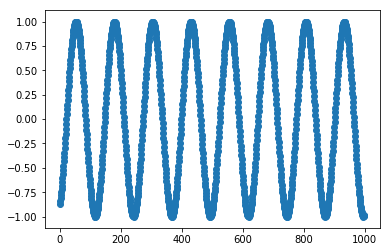

torch.Size([2, 500])


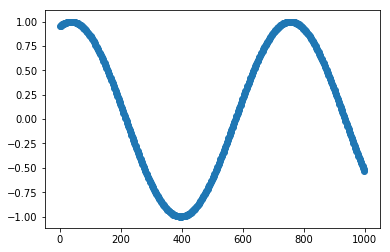

torch.Size([2, 500])


In [79]:
# Loading the data from the sequence we generated #
data = torch.load('traindata.pt')
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])

print(input.shape)
print(target.shape)
print(np.linspace(1, 999, 999).shape)
plt.scatter(np.linspace(1,999, 999), input[0])
plt.show()

data1 = [generate_sample(batch_size=2, seqlength=500, freq=(i+1)/2) for i in range(1,11)]
print(data1[0].shape)
plt.scatter(np.linspace(1,999, 500), data1[0][0])
plt.show()
print(data1[9].shape)

#### Train the network!

In [80]:
for i in range(200):
    tl = 0
    for j in range(2):
        input = data1[j]
        def closure():
            optimizer.zero_grad()
            target = input[:, 1:]
            output = net(input[:, :-1].float())

            loss = criterion(output, target.float())
            print("loss: ", loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)
    print("Epoch : ", i, " Loss : ", tl)

loss:  0.48152783513069153
loss:  0.4842253625392914
Epoch :  0  Loss :  0
loss:  0.4554980397224426
loss:  0.46237149834632874
Epoch :  1  Loss :  0
loss:  0.4297751188278198
loss:  0.43655407428741455
Epoch :  2  Loss :  0
loss:  0.39811697602272034
loss:  0.40009263157844543
Epoch :  3  Loss :  0
loss:  0.3526112735271454
loss:  0.3431563675403595
Epoch :  4  Loss :  0
loss:  0.2815227210521698
loss:  0.2521832585334778
Epoch :  5  Loss :  0
loss:  0.1716006100177765
loss:  0.1237301379442215
Epoch :  6  Loss :  0
loss:  0.056827228516340256
loss:  0.07246431708335876
Epoch :  7  Loss :  0
loss:  0.060250770300626755
loss:  0.0858016088604927
Epoch :  8  Loss :  0
loss:  0.07765147089958191
loss:  0.07972860336303711
Epoch :  9  Loss :  0
loss:  0.05242649093270302
loss:  0.04450804740190506
Epoch :  10  Loss :  0
loss:  0.02959822118282318
loss:  0.03422556817531586
Epoch :  11  Loss :  0
loss:  0.027569536119699478
loss:  0.04119100049138069
Epoch :  12  Loss :  0
loss:  0.0354086

Epoch :  103  Loss :  0
loss:  0.0031806949991732836
loss:  0.0015026405453681946
Epoch :  104  Loss :  0
loss:  0.003173169447109103
loss:  0.0014944589929655194
Epoch :  105  Loss :  0
loss:  0.0031654878985136747
loss:  0.0014865418197587132
Epoch :  106  Loss :  0
loss:  0.003157675266265869
loss:  0.001478692633099854
Epoch :  107  Loss :  0
loss:  0.003149898024275899
loss:  0.0014709130628034472
Epoch :  108  Loss :  0
loss:  0.0031420388258993626
loss:  0.0014633173123002052
Epoch :  109  Loss :  0
loss:  0.0031340657733380795
loss:  0.0014558444963768125
Epoch :  110  Loss :  0
loss:  0.003126040566712618
loss:  0.0014484780840575695
Epoch :  111  Loss :  0
loss:  0.003117969026789069
loss:  0.001441200147382915
Epoch :  112  Loss :  0
loss:  0.003109890501946211
loss:  0.0014339764602482319
Epoch :  113  Loss :  0
loss:  0.0031017882283777
loss:  0.0014268436934798956
Epoch :  114  Loss :  0
loss:  0.003093661740422249
loss:  0.0014197435230016708
Epoch :  115  Loss :  0
loss

torch.Size([1, 400])


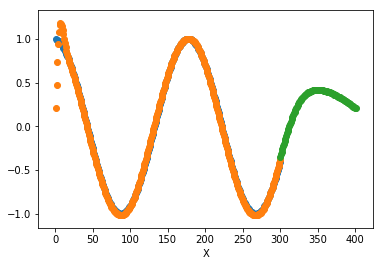

In [87]:
testseqlength=300
test = generate_sample(batch_size=1,seqlength=testseqlength,freq=2)
future=100
out = net(test,future)
print(out.shape)
plt.scatter(np.linspace(1, testseqlength, testseqlength), test.detach().numpy()[0])
plt.xlabel("X")
plt.scatter(np.linspace(1, testseqlength, testseqlength),out.detach().numpy()[0,:testseqlength])
plt.scatter(np.linspace(testseqlength, testseqlength+future+1, future), out.detach().numpy()[0,testseqlength:])

In [43]:
torch.save(net.state_dict(), 'model.pth')